# Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. 

In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? 

Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality.

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's ```get_state_history``` method. 

You can then resume execution at this previous point in time.

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# Custom State
Create a custom state having a boolean ```ask_human``` in addition to the list of messages

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

# Schema to request assistance

Next, define a schema to show the model to let it decide to request assistance.



In [4]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools+ [RequestAssistance])


In [6]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [7]:
graph_builder = StateGraph(State)

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [9]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Human Node

Create the "human" node. 

This node function is mostly a placeholder in our graph that will trigger an interrupt. 

If the human does not manually update the state during the interrupt, it inserts a tool message so the LLM knows the user was requested but didn't respond. 

This node also unsets the ask_human flag so the graph knows not to revisit the node unless further requests are made.



In [10]:
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

In [11]:
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [12]:
graph_builder.add_node("human", human_node)

# Define Conditional Logic:

Next, define the conditional logic. 

The ```select_next_node``` will route to the ```human``` node if the flag is set. 

Otherwise, it lets the prebuilt ```tools_condition``` function choose the next node.

Recall that the ```tools_condition``` function simply checks to see if the ```chatbot``` has responded with any ```tool_calls``` in its response message. 

If so, it routes to the ```action``` node. 

Otherwise, it ends the graph.

In [13]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)

In [14]:
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

# Add Edges

In [15]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [16]:
memory = MemorySaver()

In [17]:
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

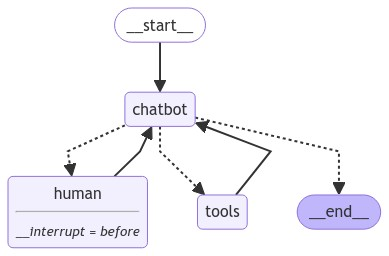

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Explaination/Interpretation:

The chat bot can either 

1. Request help from a human (chatbot->select->human)
2. Invoke the search engine tool (chatbot->select->action)
3. Directly respond (chatbot->select->end). 

Once an action or request has been made, the graph will transition back to the chatbot node to continue operations.

In [19]:
# Function to generate a unique session ID
import uuid

def generate_session_id() -> str:
    return str(uuid.uuid4())

In [20]:
# Generating a dynamic session ID
thread_id_1 = generate_session_id()
config_1 = {"configurable": {"thread_id": thread_id_1}}

In [21]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

In [22]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ixTbUH3EdLYjyyHesIRyFiIQ)
 Call ID: call_ixTbUH3EdLYjyyHesIRyFiIQ
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph with Python or JavaScript, and deploy your agents at scale with LangGraph Cloud."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn h

In [23]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it! Search on internet for that and help me.")
        ]
    },
    config_1,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it! Search on internet for that and help me.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Hqgz5mSb0vLU3efuVyDS5xJh)
 Call ID: call_Hqgz5mSb0vLU3efuVyDS5xJh
  Args:
    query: building autonomous agent with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/library/view/building-autonomous-ai/9781836643159/", "content": "Title: Building Autonomous AI Agents with LangGraph. Author (s): Paulo Dichone. Release date: August 2024. Publisher (s): Packt Publishing. ISBN: 9781836643159. Embark on a detailed journey into AI agent development with our comprehensive course. We begin with an introduction to the course structure and setting up your development environment

# Replay:
Now that we've had the agent take a couple steps, we can replay the full state history to see everything that occurred.



In [24]:
to_replay = None
for state in graph.get_state_history(config_1):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------


# Notice:

Checkpoints are saved for every step of the graph. This spans invocations so you can rewind across a full thread's history. We've picked out ```to_replay``` as a state to resume from. This is the state after the chatbot node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [25]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': 'd7279d1a-8403-4292-93ea-662c09e9ec03', 'checkpoint_ns': '', 'checkpoint_id': '1ef638a3-ba62-6ae6-8006-9980c02e988f'}}


Notice:

The checkpoint's config (```to_replay.config```) contains a ```thread_ts``` timestamp. Providing this ````thread_ts``` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [26]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/library/view/building-autonomous-ai/9781836643159/", "content": "Title: Building Autonomous AI Agents with LangGraph. Author (s): Paulo Dichone. Release date: August 2024. Publisher (s): Packt Publishing. ISBN: 9781836643159. Embark on a detailed journey into AI agent development with our comprehensive course. We begin with an introduction to the course structure and setting up your development environment."}, {"url": "https://medium.com/@Shrishml/a-primer-on-ai-agents-with-langgraph-understand-all-about-it-0534345190dc", "content": "Task-driven Autonomous Agent Utilizing GPT-4, Pinecone, and LangChain for Diverse Applications. ... LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends the ..."}]
================================== Ai Message ==================================

Here are some resources t

# Notice:

The graph resumed execution from the ```**action**``` node. You can tell this is the case since the first value printed above is the response from our search engine tool.

We've now used time-travel checkpoint traversal in LangGraph. 

Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive application